# Don't do math and drive

<h1 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; top: 60px;right: 30px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png" style="width:100px" />
    <img src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png" style="width:100px" />
</h1>
<h2 style="height: 10px">
</h2>

*[CEGM1000 MUDE](http://mude.citg.tudelft.nl/): Week 2.5. For: 13th December, 2024.*

# Problem description

_Note: part of the background material for this project was already available in the textbook._

In this assignment, the goal is to minimize the total travel time on the network by selecting a predefined number of links for capacity expansion (subject to the available budget).

The road network design problem (NDP) is the problem of determining which links to build/refurbish/upgrade in order to improve the performance of a road network. One of the variations of the road NDP is the road NDP with capacity expansions, which involves deciding which links should have their capacity increased. This is a complex problem that must take into account a variety of factors, including:

* The current state of the road network
* The projected future traffic demand
* The budget available for improvements
* The impacts of the adjustments (could be environmental, social, etc).

There are a variety of approaches to dealing with the road network design problem with capacity expansion. One common approach is to use mathematical optimization models. In this assignment we use a simplified example to show how optimization can be used to tackle road NDPs.

The following (main) assumptions and simplifications are made to make the problem solvable using methods and algorithms that you have learned so far:

### 1. Link travel time function
Travel time on a stretch of road (i.e., a link) depends on the flow (vehicles/hour) on that link and the capacity of the link (maximum of vehicles/hour). The most common function to calculate travel time on a link is the so-called Bureau of Public Roads (BPR) function, which is a polynomial (degree 4) function:

$${t_{ij}} = t_{ij}^0\left( {1 + \alpha {{\left( {\cfrac{x_{ij}}{c_{ij}}} \right)}^\beta }} \right) \quad \left( {i,j} \right) \in A$$

Where $t_{ij}$ is the current travel time on the link, $t_{ij}^0$ is the travel time without congestion (free flow), $x_{ij}$ is the flow of cars, and $c_{ij}$ the capacity in maximum flow of cars. $\alpha$ and $\beta$ are calibration parameters. More details are provided within the formulation section.

Here, we assumme a simplified linear function where travel time grows linearly with the flow of vehicles on a road link, which will be described later in the notebook.

### 2. Route choice behavior
In order to assess the quality of the road capacity expansion problem, one must know what the effect of the added capacity is on travel time. The route choice behavior of drivers within congested networks often follows the so-called User Equilibrium (UE) principle where each traveller tries to minimize their own individual generalized travel time. 

However, calculating the UE requires advanced methods which are not covered in the MUDE. Therefore, here we assume the route choice behaviour follows the so-called System Optimal (SO) principle, which implies that route choices are made in such a way that the total travel time is minimized (summed over all the drivers). That means that some cars will drive longer routes so that other cars can save time. But have in mind that in real life road networks you can hardly obtain a system optimal traffic distribution!


Using the simplifcations and assumptions referred to above we can formulate an NDP and solve it using the branch and bound method (that you have studied before).


<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"> <p> <b>Note:</b> You will need to select mude-week-2-5 as your kernel as it includes the required packages.</p></div>


## Part 1: Data preprocessing

The demand of the network is given by an **OD matrix**, which will be constructed below. The OD matrix is a table that tells you how many cars go from node i to node j in an a given timeframe. The functions for this can be found in the helper function in utils/read.py. You do not need to edit anything in this codeblock.

In [1]:
import gurobipy as gp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# import required packages
import os
import time

# import required functions
from utils.read import read_cases
from utils.read import read_net
from utils.read import read_od
from utils.read import create_nd_matrix

### Visualisation

In this section, we'll initially visualize the network using the coordinates of the sample road network, 'SiouxFalls'. Later, we'll employ the same network topology to visualize the upgraded links.

Thankfully, Python offers a highly useful package for visualizing networks called **'networkx'**. We'll leverage some of its features, so:

The code block below will generate the road network that we are using in the assessment, Sioux Falls.

In [3]:
# For visualization
import networkx as nx
import json
from matplotlib.lines import Line2D 
from utils.network_visualization import network_visualization
from utils.network_visualization_highlight_link import network_visualization_highlight_links
from utils.network_visualization_upgraded import network_visualization_upgraded

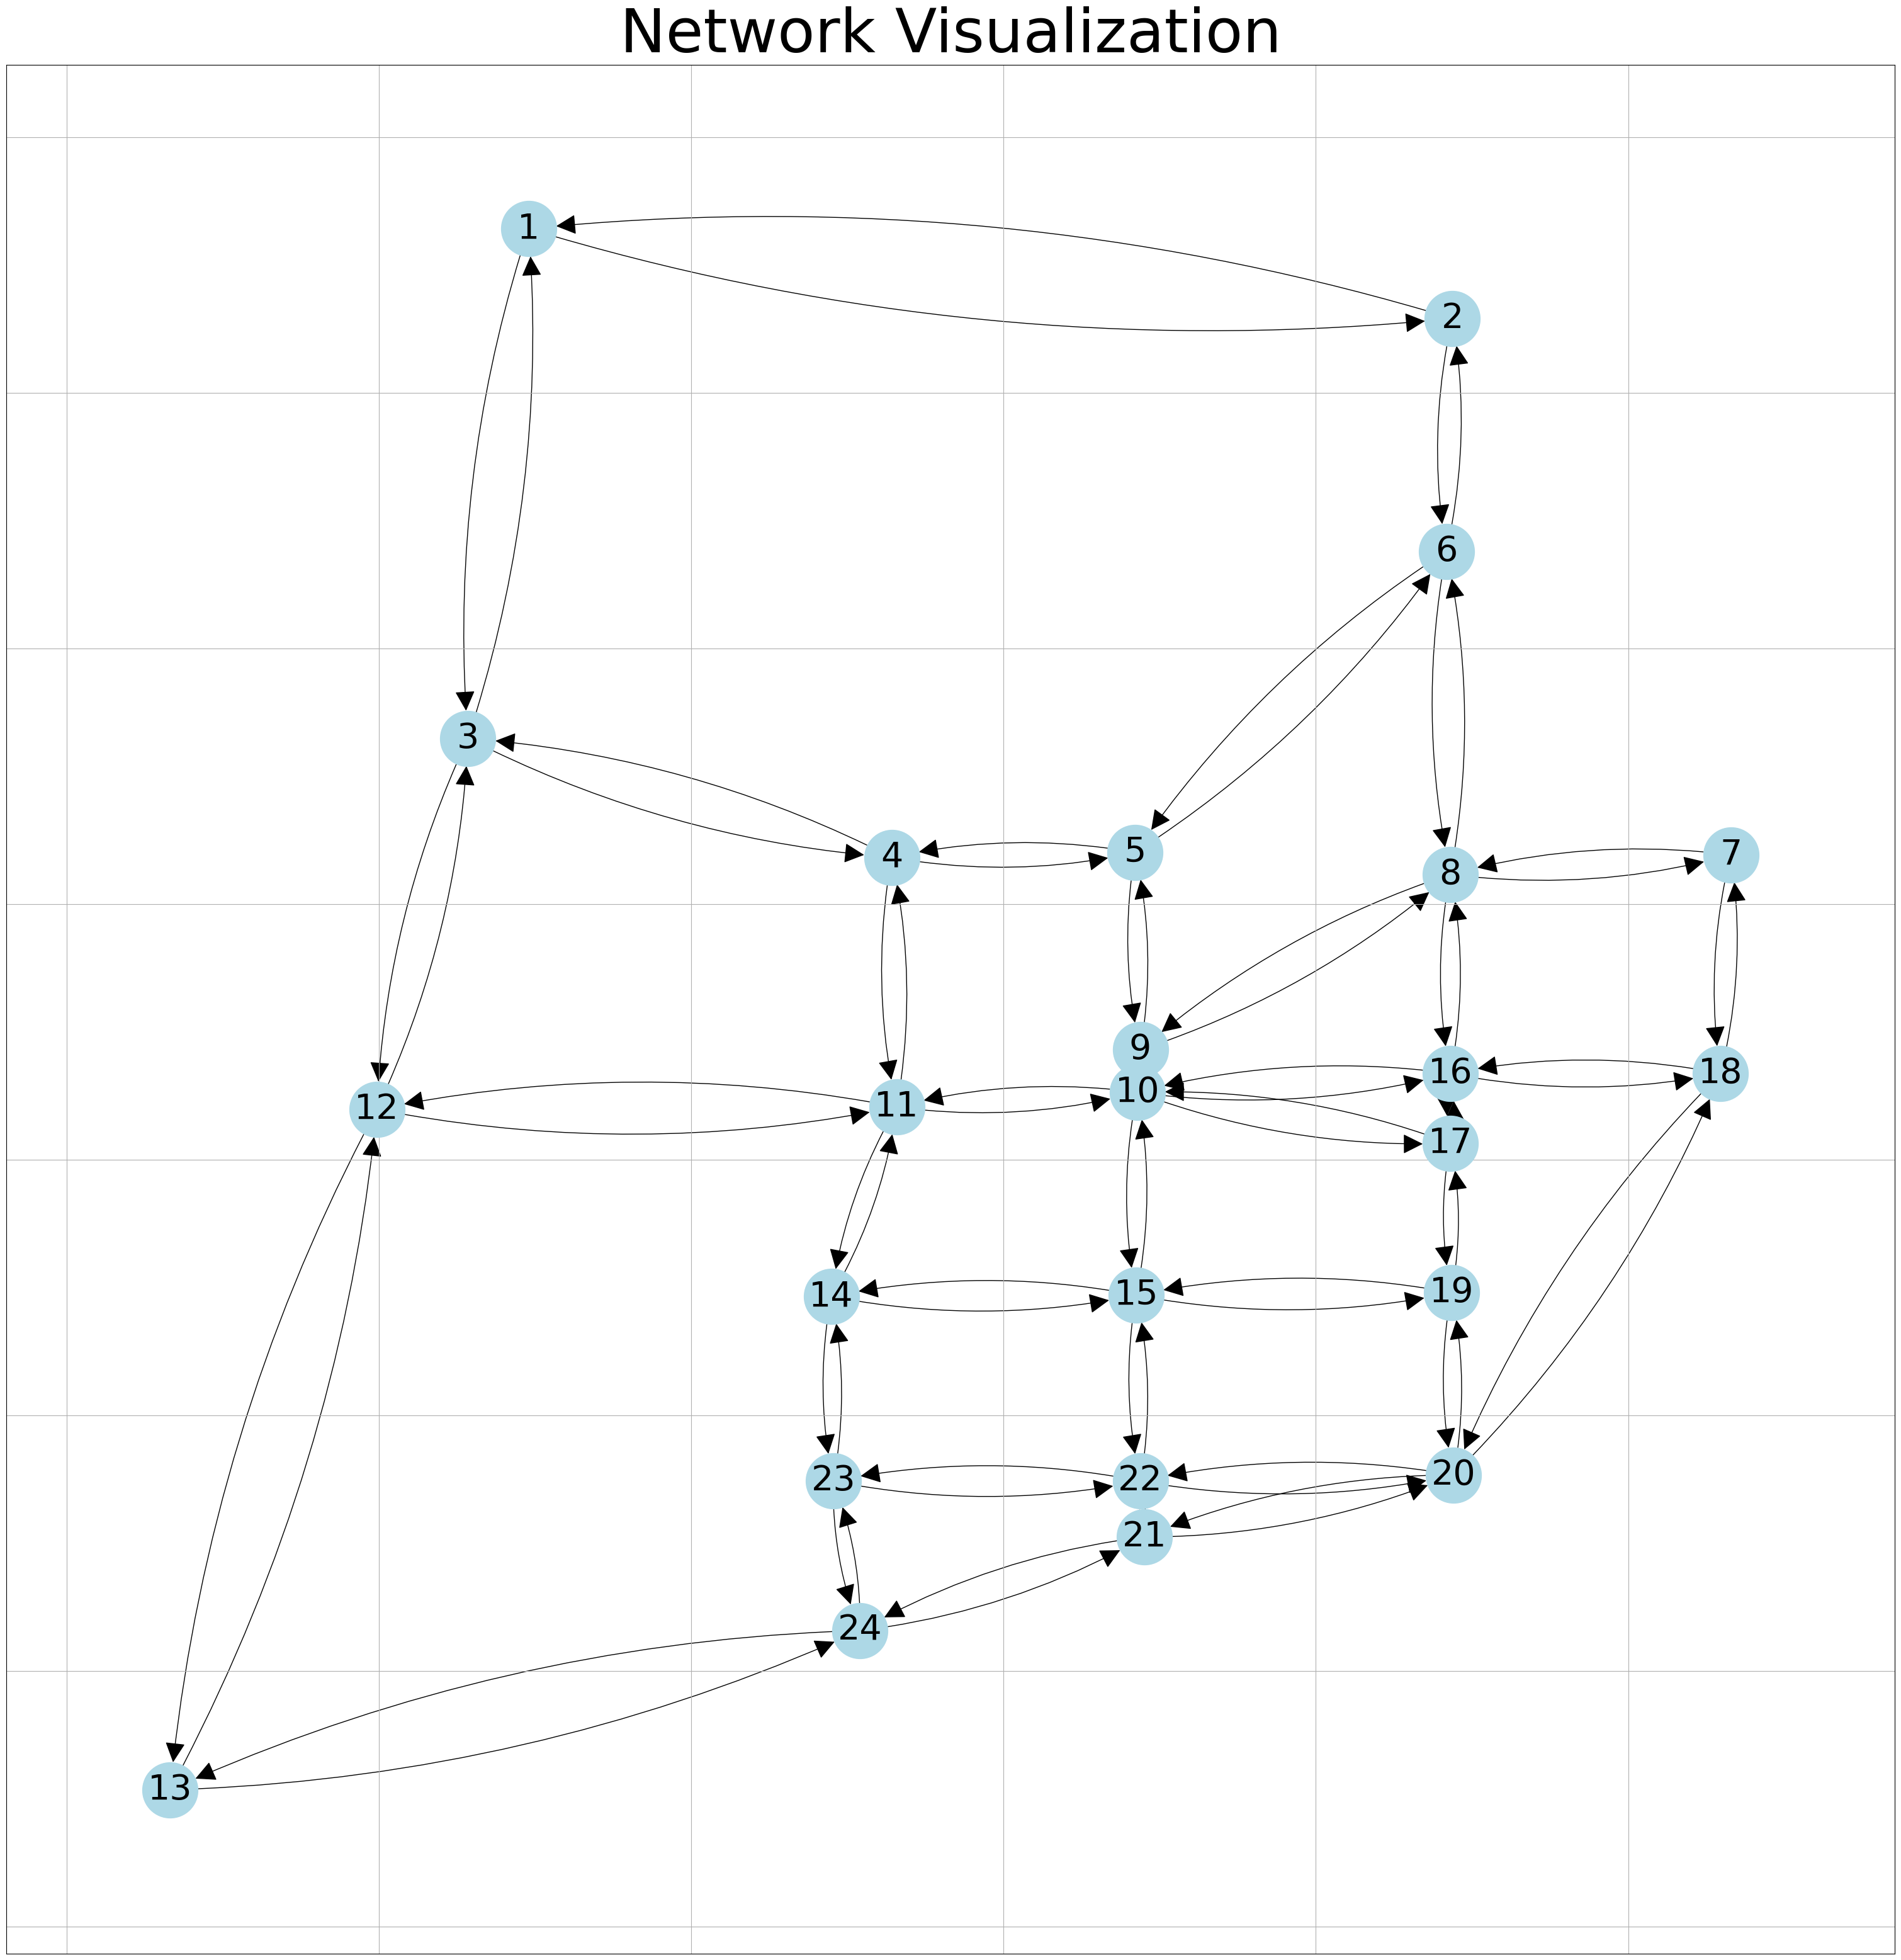

In [4]:
# We are using the SiouxFalls network which is one of the most used networks in transportation reseach: https://github.com/bstabler/TransportationNetworks/blob/master/SiouxFalls/Sioux-Falls-Network.pdf
networks = ['SiouxFalls']
networks_dir = 'input/TransportationNetworks'

net_dict, ods_dict = read_cases(networks, networks_dir)
net_data, ods_data = net_dict[networks[0]], ods_dict[networks[0]]

## now let's prepare the data in a format readable by gurobi
links = list(net_data['capacity'].keys())
nodes = np.unique([list(edge) for edge in links])
fftts = net_data['free_flow']

# Visualise
coordinates_path = 'input/TransportationNetworks/SiouxFalls/SiouxFallsCoordinates.geojson'
G, pos = network_visualization(link_flow = fftts,coordinates_path= coordinates_path) 

Feel free to explore further functionalities of the **networkx** package in its [documentation](https://networkx.org/documentation/stable/reference/index.html).

Interested in visualizing other networks? Fantastic! However, you'll need to check the format of your coordinates first. TAs will assist you if you wish to explore further.

### OD Matrix

Here, the OD matrix is read.

The first code block gives you a printout of the first 5 rows of the matrix. The second creates a heatmap of the flow values inside the OD matrix.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = ods_data

max_origin = max(key[0] for key in data.keys())
max_destination = max(key[1] for key in data.keys())

od_matrix = pd.DataFrame(index=range(1, max_origin + 1), columns=range(1, max_destination + 1))

for key, value in data.items():
    od_matrix.loc[key[0], key[1]] = value

print("Origin-Destination Matrix:")
print(od_matrix.head(5))

Origin-Destination Matrix:
      1      2      3      4      5      6      7      8      9       10  ...  \
1      0  100.0  100.0  500.0  200.0  300.0  500.0  800.0  500.0  1300.0  ...   
2  100.0      0  100.0  200.0  100.0  400.0  200.0  400.0  200.0   600.0  ...   
3  100.0  100.0      0  200.0  100.0  300.0  100.0  200.0  100.0   300.0  ...   
4  500.0  200.0  200.0      0  500.0  400.0  400.0  700.0  700.0  1200.0  ...   
5  200.0  100.0  100.0  500.0      0  200.0  200.0  500.0  800.0  1000.0  ...   

      15     16     17     18     19     20     21     22     23     24  
1  500.0  500.0  400.0  100.0  300.0  300.0  100.0  400.0  300.0  100.0  
2  100.0  400.0  200.0      0  100.0  100.0      0  100.0      0      0  
3  100.0  200.0  100.0      0      0      0      0  100.0  100.0      0  
4  500.0  800.0  500.0  100.0  200.0  300.0  200.0  400.0  500.0  200.0  
5  200.0  500.0  200.0      0  100.0  100.0  100.0  200.0  100.0      0  

[5 rows x 24 columns]


C:\Users\jdding\AppData\Local\Temp\ipykernel_22916\285084469.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  od_matrix = od_matrix.fillna(0).astype(float)


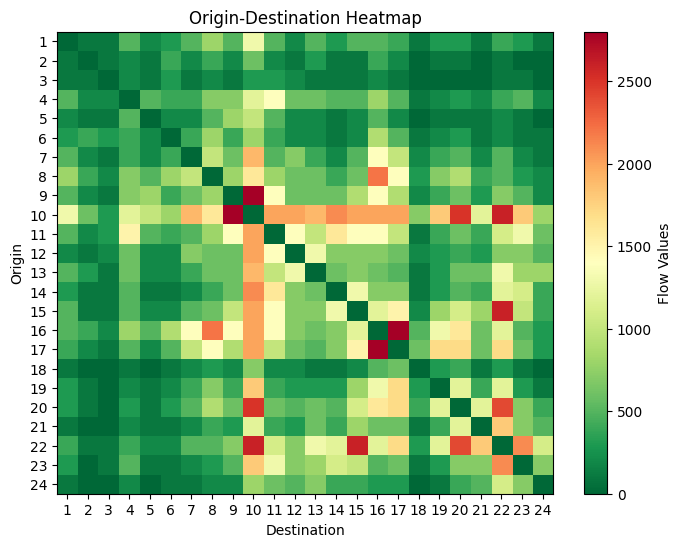

In [6]:
# Convert to numeric and handle NaN
od_matrix = od_matrix.fillna(0).astype(float)

# Plotting the Heatmap
plt.figure(figsize=(8, 6))
plt.title("Origin-Destination Heatmap")
plt.xlabel("Destination")
plt.ylabel("Origin")
plt.imshow(od_matrix.values, cmap='RdYlGn_r', aspect="auto", interpolation="nearest")
plt.colorbar(label="Flow Values")
plt.xticks(ticks=np.arange(od_matrix.shape[1]), labels=od_matrix.columns)
plt.yticks(ticks=np.arange(od_matrix.shape[0]), labels=od_matrix.index)
plt.show()

## Part 2: Modeling in Gurobi

### Defining Parameters

Now that we have the required functions for reading and processing the data, let's define some problem parameters and prepare the input. 

In [7]:
# define parameters
extension_factor = 2.5  # capacity after extension
extension_max_no = 40  # simplified budget limit
timelimit = 300  # seconds
beta = 2  # explained later

# auxiliary parameters 
cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}

# origins and destinations
origs = np.unique([orig for (orig, dest) in list(ods_data.keys())])
dests = np.unique([dest for (orig, dest) in list(ods_data.keys())])

# OD-matrix is built
demand = create_nd_matrix(ods_data, origs, dests, nodes)

### Initiate the Gurobi model

First, let's build a gurobi model object and define some parameters based on the model type. We have a mixed integer quadratic program (MIQP), that's because the objective function has a quadratic term, which we want to transform to a mixed integer linear program (MILP) and solve using the branch and bound method. We discuss the transformations from quadratic to linear when we introduce quadratic terms.

In [8]:
## create a gurobi model object
model = gp.Model()

model.params.TimeLimit = timelimit  
model.params.NonConvex = 2 
model.params.PreQLinearize = 1

Set parameter Username
Set parameter LicenseID to value 2588551
Academic license - for non-commercial use only - expires 2025-11-21
Set parameter TimeLimit to value 300
Set parameter NonConvex to value 2
Set parameter PreQLinearize to value 1


### Decision variables

We have a set of binary variables $y_{ij}$, these variables take the value 1 if link $(i,j)$ connecting node $i$ to node $j$ is selected for expansion, and 0 otherwise.

We also have two sets of decision variables representing link flows; $x_{ij}$, representing flow on link $(i,j)$ in cars per hour, and $x_{ijs}$, representing flow on link $(i,j)$ going to destination $s$.

The first is the number of total cars passing on that road, and the second is the number of cars that are passing on the road which are specifically going to destination $s$. Summing the latter over all $s$ results in the former for a link $(i,j)$.

Therefore, mathematically we define the domain of the variables as follows:

\begin{align}
  & y_{ij} \in \{0, 1\} \quad \forall (i,j) \in A \\
  & x_{ij} \geq 0 \quad \forall (i,j) \in A \\
  & x_{ijs} \geq 0 \quad \forall (i,j) \in A, \forall s \in D \\
\end{align}

As you will see below in the code block, we have one extra set of variables called x2 (x square). This is to help Gurobi isolate quadratic terms and perform required transformations based on MCE to keep the problem linear. This is not part of your learning goals.

In [9]:
# decision variables:

link_selected = model.addVars(links, vtype=gp.GRB.BINARY, name='y')
link_flow = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x')
dest_flow = model.addVars(links, dests, vtype=gp.GRB.CONTINUOUS, name='xs')

link_flow_sqr = model.addVars(links, vtype=gp.GRB.CONTINUOUS, name='x2')


### Objective function

The objective function of the problem (in its simplest form), is the minimization of the total travel time on the network, that means that you multiply the flow of vehicles in each link by the corresponding travel time and sum over all links ($A$ is the collection of all links to simplify the notation):

$Z = \sum_{(i,j)\in A}{ x_{ij} . t_{ij}} $

The travel time $t_{ij}$ is a function of the flow on a link and can be expressed as follows (where beta is a parameter):

$ t_{ij} = t^0_{ij} . ( 1 + \beta (x_{ij}/c_{ij}))  \quad \forall (i,j) \in A  $

> Note that the commonly used travel time function based on the Bureau of Public Roads (BPR) is as follows:
> 
> $ t_{ij} = t^0_{ij} . ( 1 + \alpha (x_{ij}/c_{ij})^\beta)  \quad \forall (i,j) \in A  $
> 
> Where $\beta$ usually assumes the value of $4$ making this function (and the problem) non-linear. Therefore, we use the linear function mentioned before to make the problem manageable using what we have learned so far.

The following constraint yields the capacity of each link based on which ones are selected for expansion, when y is 1 there is added capacity as you can see:

$ c_{ij} = (1 - y_{ij}) . c^0_{ij} +  y_{ij} . c^1_{ij}  \quad \forall (i,j) \in A   $

This allows us to represent $t_{ij}$ as:

$ t_{ij} = t^0_{ij} . ( 1 + \beta (x_{ij} * ((1 - y_{ij})/c^0_{ij} +  y_{ij}/c^1_{ij} )))  \quad \forall (i,j) \in A  $

Which leads to the following extended objective funtion:

$ Z = \sum_{(i,j) \in A}{ x_{ij} . (t^0_{ij} . ( 1 + \beta (x_{ij} * ((1 - y_{ij})/c^0_{ij} +  y_{ij}/c^1_{ij} ))))} $

Now, for gurobi (and other solvers as well), we have to keep binary variables and quadratic terms clean and separate so that it can perform the required transformations to linearize the problem. Therefore, the equation below, despite being very big, would be the most solver-friendly formulation of our objective function:

\begin{align}
  Z = \sum_{(i,j) \in A}{t^0_{ij} . x_{ij}} + \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij}} - \sum_{(i,j) \in A}{(t^0_{ij}.\beta /c^0_{ij}) . x^2_{ij} . y_{ij}} + \sum_{(i,j) \in A}{t^0_{ij}.(\beta /c^1_{ij}) . x^2_{ij} . y_{ij}}  \\
\end{align}

Therefore, we use this equation to model our objective function in gurobi. You do not need to know fully understand this equation.


In [10]:
# objective function (total travel time)

model.setObjective(
    gp.quicksum(fftts[i, j] * link_flow[i, j] +
                fftts[i, j] * (beta/cap_normal[i, j]) * link_flow_sqr[i, j] -
                fftts[i, j] * (beta/cap_normal[i, j]) * link_flow_sqr[i, j] * link_selected[i, j] +
                fftts[i, j] * (beta/cap_extend[i, j]) * link_flow_sqr[i, j] * link_selected[i, j]
                for (i, j) in links))

### Constraints

We have four sets of constraints for this problem. Let's go through them one by one and add them to the model.

#### 1. Budget constraint
We can only extend the capacity of certain number of links based on the available budget. So first, we have to make sure to limit the number of extended links to the max number that can be expanded:

$ \sum_{(i,j) \in A}{ y_{ij}} = B $

In [11]:
# budget constraint
c_bgt = model.addConstr(gp.quicksum(link_selected[i, j] for (i, j) in links) <= extension_max_no)

#### 2. Link flow conservation constraints
We have two sets of decision variables representing link flows; $x_{ij}$, representing flow on link $(i,j)$, and $x_{ijs}$, representing flow on link $(i,j)$ going to destination $s$. So we have to make sure that the sum of the flows over all destinations equals the flow on each link.
$ \sum_{s \in D}{x_{ijs}} = x_{ij} \quad \forall (i,j) \in A $

In [12]:
# link flow conservation
c_lfc = model.addConstrs(gp.quicksum(dest_flow[i, j, s] for s in dests) == link_flow[i, j] for (i, j) in links)

#### 3. Node flow conservation constraints
The basic idea of this constraint set is to make sure that the incoming and outgoing flow to and from each node is the same (hence flow conservation) with the exception for origin and destination nodes of the trips where there will be extra outgoing flow (origins) or incoming flow (destinations). Think about a traffic intersection, vehicles enter and leave the intersection when they are moving in the network. This assures the continuity of the vehicle paths. $d_is$ here is the number of travelers from node $i$ to node $s$ with the exception of $d_ss$, which is all the demand that arrives at node $s$.

$ \sum_{j \in N; (i,j) \in A}{ x_{ijs}} - \sum_{j \in N; (j,i) \in A}{ x_{jis}} = d_{is} \quad \forall i \in N, \forall s \in D $

The figure gives an example:

![image](./figs/equil.png)

In [13]:
# node flow conservation
c_nfc = model.addConstrs(
    gp.quicksum(dest_flow[i, j, s] for j in nodes if (i, j) in links) -
    gp.quicksum(dest_flow[j, i, s] for j in nodes if (j, i) in links) == demand[i, s]
    for i in nodes for s in dests
)

#### 4. Quadratic variable constraints (you do not need to fully understand this)
These are basically dummy equations to help gurobi model quadratic terms (that we defined as dummy variables earlier). So essentially instead of using $x^2_{ij}$ in the model, we define a new set of decision variables and define a set of constrains to set their value to $x^2_{ij}$. This let's Gurobi know these are quadratic terms and helps gurobi to replace it with variables and constraints required to keep the problem linear. This is not part of your learning goals! 


In [14]:
# dummy constraints for handling quadratic terms
c_qrt = model.addConstrs(link_flow_sqr[i, j] == link_flow[i, j] * link_flow[i, j] for (i, j) in links)

### Additional constraint for question 3

<div style="background-color:#ffa6a6; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Note:</b> Do NOT run this cell in the first instance. We first run the model without this constraint. In task 3, you will be asked to define this constraint and rerun the ENTIRE model. You should then restart the kernel and run again. </p></div>

In [15]:
# constrain the vehicles to the capacity of the road:
c_new = model.addConstrs(link_flow[i, j] <= cap_normal[i,j] + ((cap_extend[i,j]-cap_normal[i,j] ) * link_selected[i,j])  for (i, j) in links)

<div style="background-color:#facb8e; color: black; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px; width: 95%"><p><b>Note:</b> Maximum computation time (termination criteria) is set here as a keyword argument in the code cello beneath the 'Part 2' heading.</p></div>

In [16]:
#Next we are ready to solve the model
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Non-default parameters:
TimeLimit  300
NonConvex  2
PreQLinearize  1

Optimize a model with 729 rows, 2052 columns and 5776 nonzeros
Model fingerprint: 0x889403a4
Model has 76 quadratic objective terms
Model has 76 quadratic constraints
Variable types: 1976 continuous, 76 integer (76 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [2e-04, 1e+01]
  QObjective range [2e-04, 5e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+01, 4e+04]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 1108 rows, 2280 columns, 6535 nonzeros
Presolved model has 152 SOS constraint(s)
Presolved model has 76 bilinear constraint(s)

Solv

Note that if you didn't find a solution, you can rerun the previous cell to continue the optimization for another 300 seconds (defined by `timelimit`).

In [17]:
# fetch optimal decision variables and Objective Function values
link_flows = {(i, j): link_flow[i, j].X for (i, j) in links}
links_selected = {(i, j): link_selected[i, j].X for (i, j) in links}
total_travel_time = model.ObjVal

# Let's print right now the objective function
print("Optimal Objective function Value", model.objVal)

# Let's print right now the decision variables
for var in model.getVars():
    print(f"{var.varName}: {round(var.X, 3)}")  # print the optimal decision variable values.

Optimal Objective function Value 8301076.699009905
y[1,2]: 0.0
y[1,3]: 0.0
y[2,1]: 0.0
y[2,6]: 0.0
y[3,1]: 0.0
y[3,4]: 0.0
y[3,12]: 0.0
y[4,3]: 0.0
y[4,5]: 0.0
y[4,11]: 1.0
y[5,4]: 0.0
y[5,6]: 1.0
y[5,9]: 0.0
y[6,2]: 0.0
y[6,5]: 1.0
y[6,8]: 1.0
y[7,8]: 1.0
y[7,18]: 0.0
y[8,6]: 1.0
y[8,7]: 1.0
y[8,9]: 0.0
y[8,16]: 0.0
y[9,5]: 1.0
y[9,8]: 0.0
y[9,10]: 1.0
y[10,9]: 1.0
y[10,11]: 1.0
y[10,15]: 1.0
y[10,16]: 1.0
y[10,17]: 1.0
y[11,4]: 1.0
y[11,10]: 1.0
y[11,12]: 1.0
y[11,14]: 1.0
y[12,3]: 0.0
y[12,11]: 1.0
y[12,13]: 0.0
y[13,12]: 0.0
y[13,24]: 1.0
y[14,11]: 0.0
y[14,15]: 0.0
y[14,23]: 1.0
y[15,10]: 1.0
y[15,14]: 0.0
y[15,19]: 1.0
y[15,22]: 1.0
y[16,8]: 0.0
y[16,10]: 1.0
y[16,17]: 1.0
y[16,18]: 0.0
y[17,10]: 1.0
y[17,16]: 1.0
y[17,19]: 1.0
y[18,7]: 0.0
y[18,16]: 0.0
y[18,20]: 0.0
y[19,15]: 1.0
y[19,17]: 1.0
y[19,20]: 0.0
y[20,18]: 0.0
y[20,19]: 1.0
y[20,21]: 0.0
y[20,22]: 0.0
y[21,20]: 0.0
y[21,22]: 1.0
y[21,24]: 1.0
y[22,15]: 1.0
y[22,20]: 1.0
y[22,21]: 1.0
y[22,23]: 0.0
y[23,14]: 0.0
y[23,

### Network Visualization

#### 1. Network visualization with highlighted links

Now, let's visualize the results showcasing congested traffic flows and the selected links for expansion. 
In this graph, we'll observe the network's topology using node coordinates and links. Our graph will be **directional** to represent the road network.

Nodes are depicted in blue, while selected nodes and links are highlighted in pink and red.

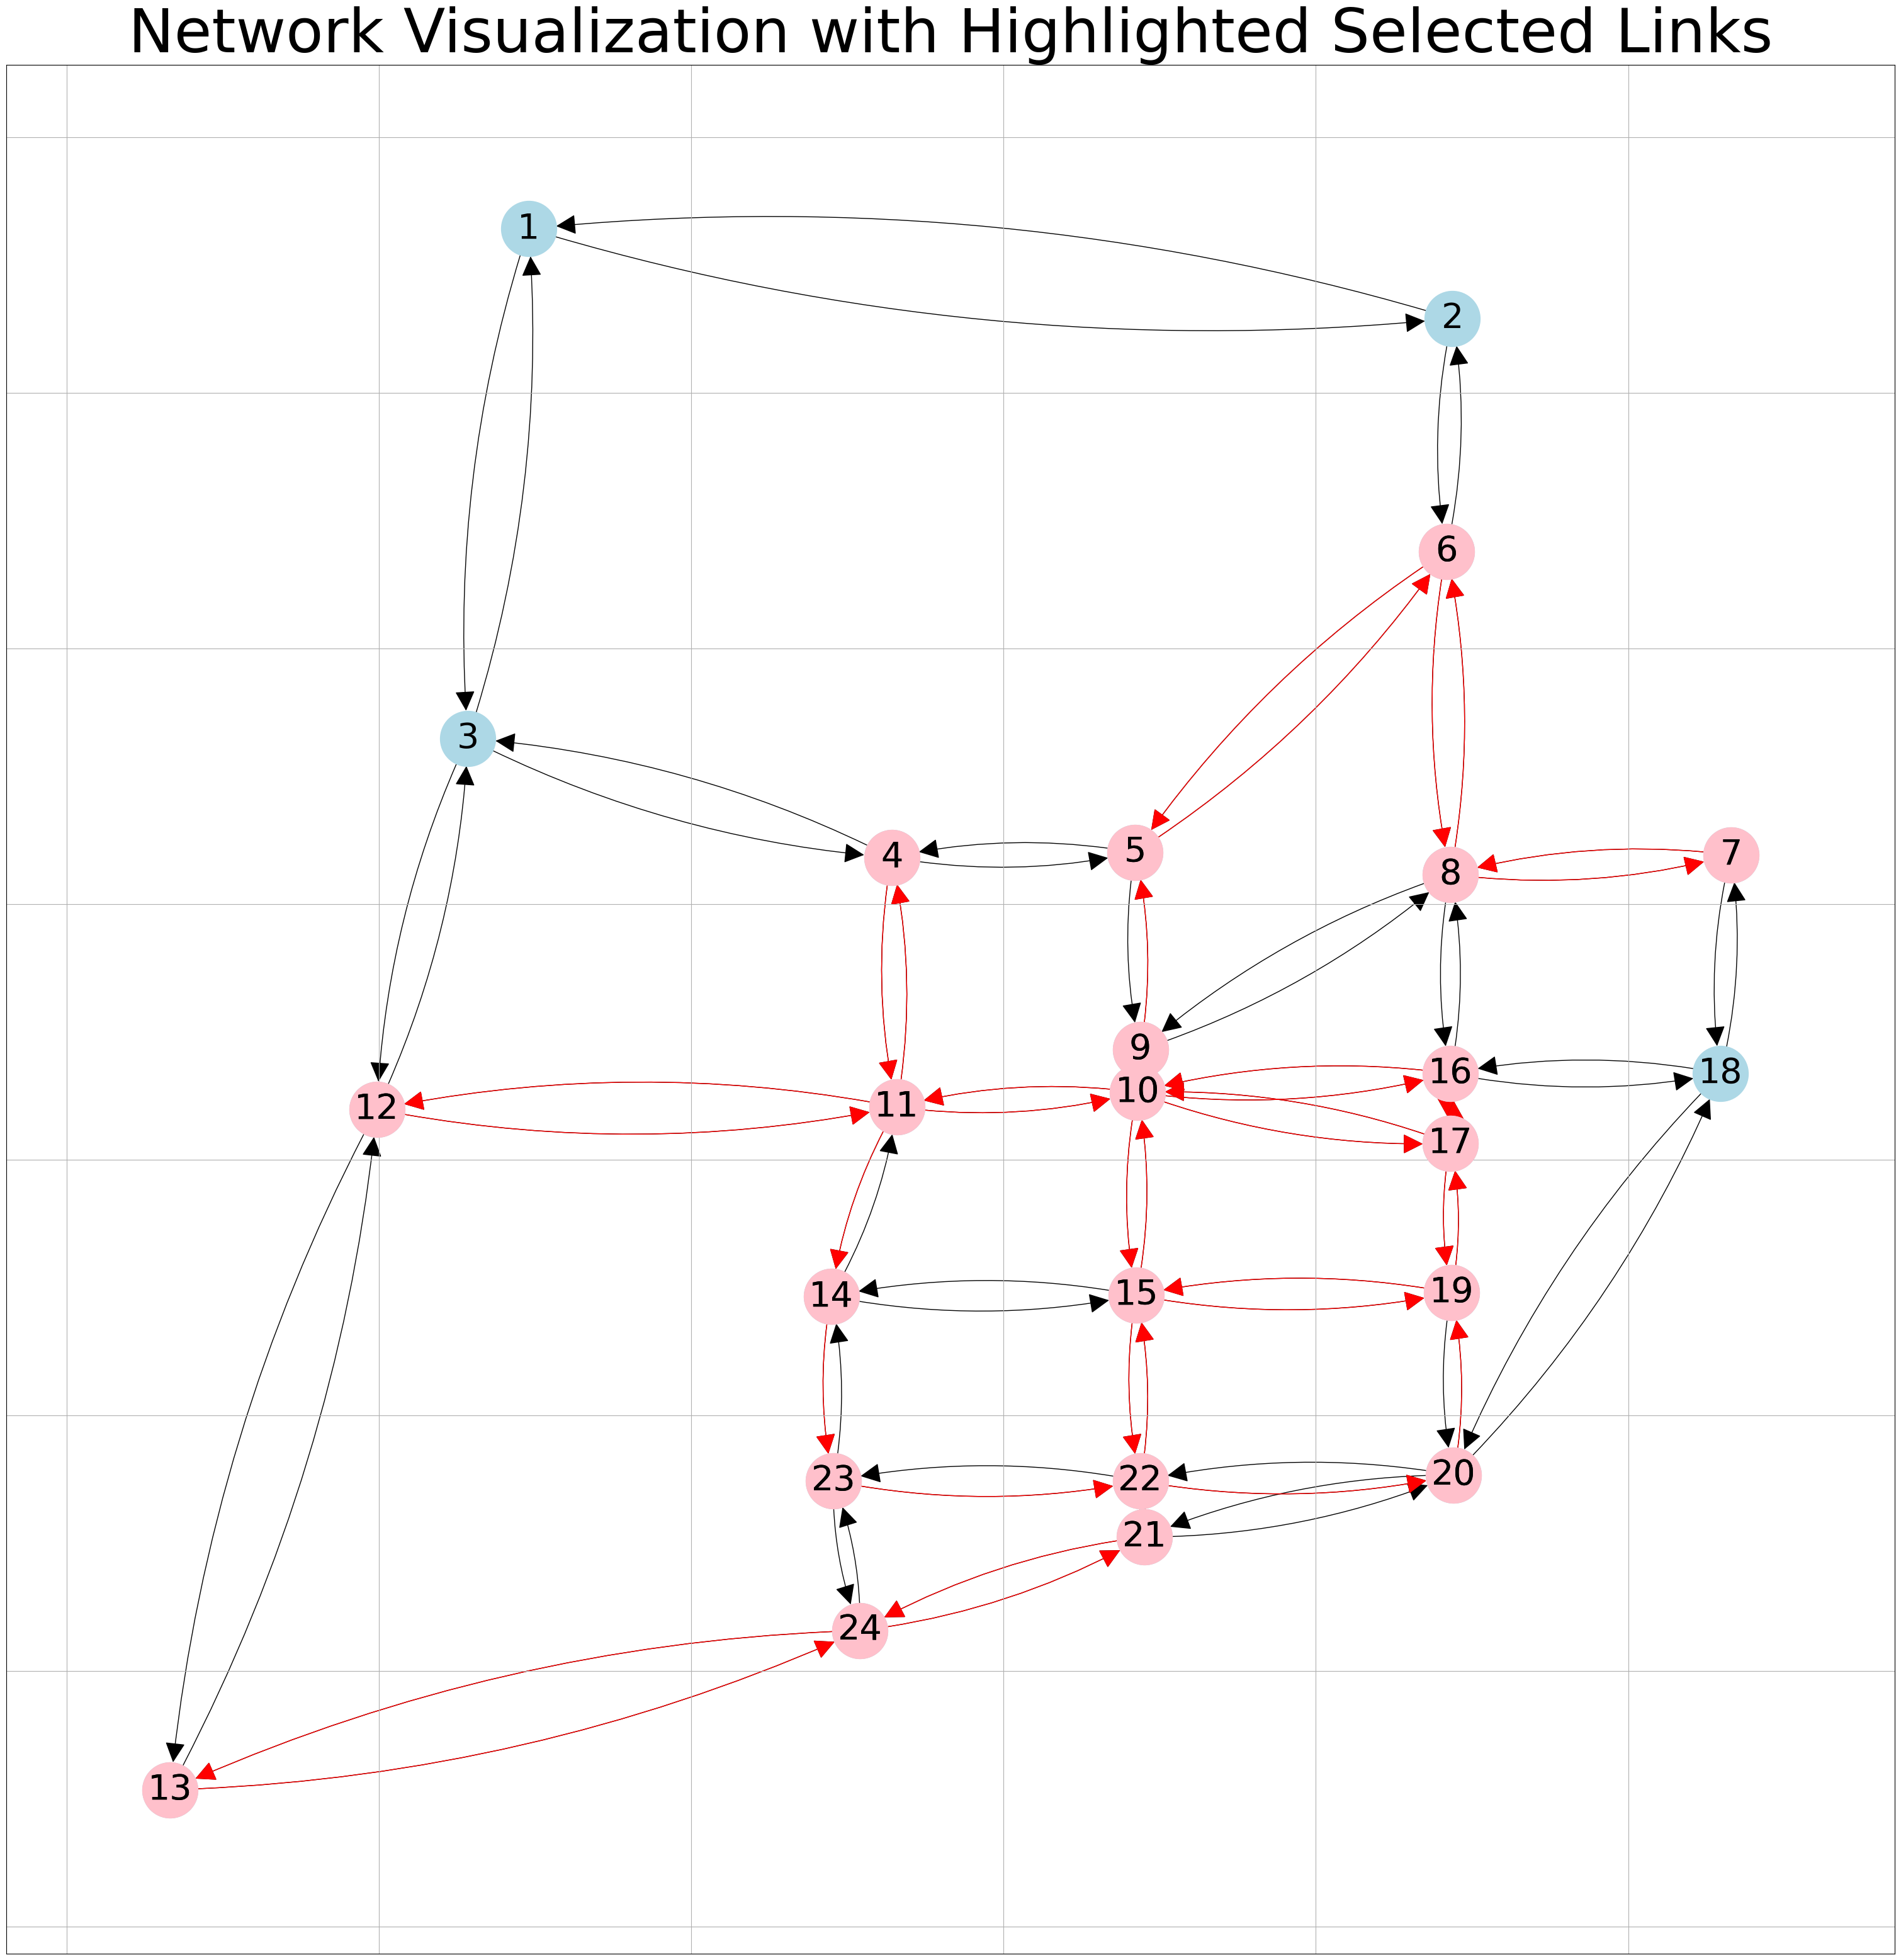

In [18]:
network_visualization_highlight_links (G, pos, link_select=links_selected)

#### 2. Network visualization with upgraded links



In this section, we'll visualize our upgraded network, incorporating the new capacities. Following that, we'll represent the network along with its results, displaying the flow (F) and capacity (C) alongside each link.

**Notes:**

1. **Pink nodes** highlight the selected nodes.
2. **Colored edges** denote the upgraded edges selected through the optimization process.
3. Various **edge colors** indicate different ranges for edge attributes (Flow/Capacity), as demonstrated in the legend.
4. Diverse **edge widths** represent varying flow ranges on the edges.
5. Your plot is interactive; to clearly view the numbers, simply click on them!

In [19]:
# Define new capacity after expansion
cap_normal = {(i, j): cap for (i, j), cap in net_data['capacity'].items()}
cap_extend = {(i, j): cap * extension_factor for (i, j), cap in net_data['capacity'].items()}
capacity = {(i, j): cap_normal[i, j] * (1 - links_selected[i, j]) + cap_extend[i, j] * links_selected[i, j]
            for (i, j) in links}

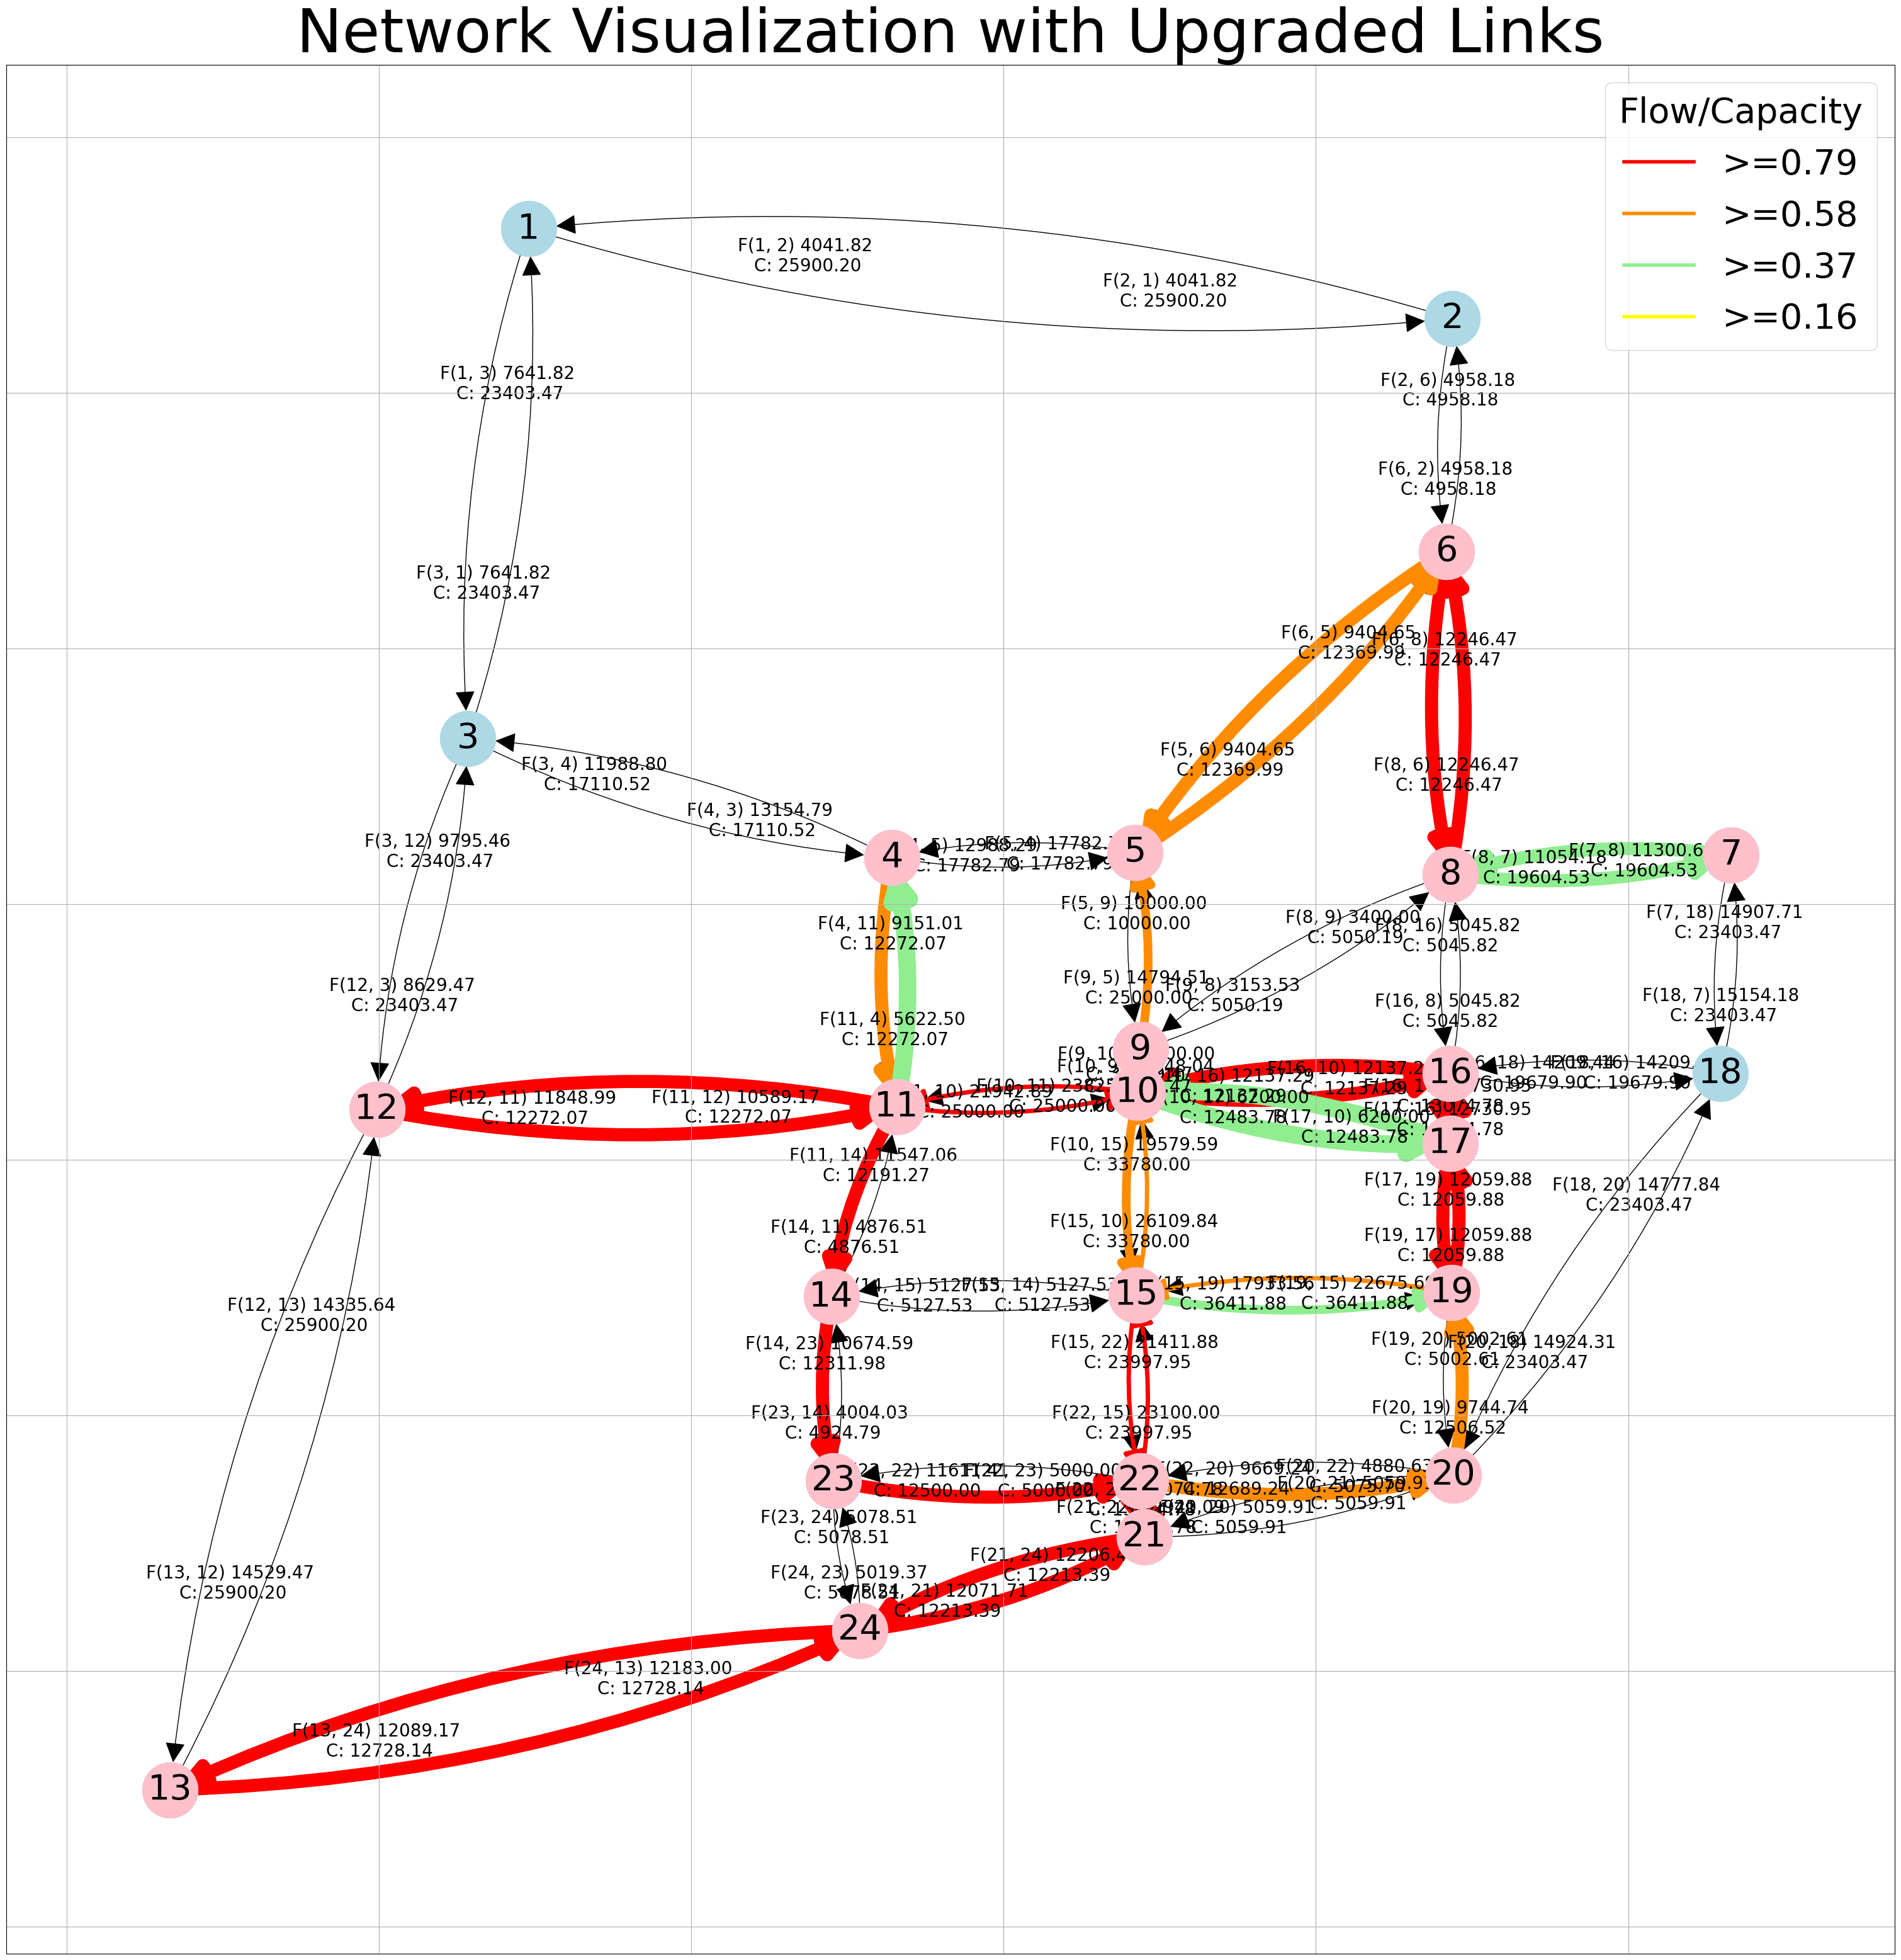

In [21]:
# To see flow and capacity for the entire network
network_visualization_upgraded (G = G, pos=pos, link_flow=link_flows, capacity_new=capacity ,link_select=links_selected, labels='on')

**End of notebook.**
<h2 style="height: 60px">
</h2>
<h3 style="position: absolute; display: flex; flex-grow: 0; flex-shrink: 0; flex-direction: row-reverse; bottom: 60px; right: 50px; margin: 0; border: 0">
    <style>
        .markdown {width:100%; position: relative}
        article { position: relative }
    </style>
    <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
      <img alt="Creative Commons License" style="border-width:; width:88px; height:auto; padding-top:10px" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" />
    </a>
    <a rel="TU Delft" href="https://www.tudelft.nl/en/ceg">
      <img alt="TU Delft" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/tu-logo/TU_P1_full-color.png"/>
    </a>
    <a rel="MUDE" href="http://mude.citg.tudelft.nl/">
      <img alt="MUDE" style="border-width:0; width:100px; height:auto; padding-bottom:0px" src="https://gitlab.tudelft.nl/mude/public/-/raw/main/mude-logo/MUDE_Logo-small.png"/>
    </a>
    
</h3>
<span style="font-size: 75%">
&copy; Copyright 2023 <a rel="MUDE Team" href="https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=65595">MUDE Teaching Team</a> TU Delft. This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.